
# Part 3 — Enhancements (biLSTM, biGRU, CNN) — Using Best Config from Part 2

**Best config (from Part 2):**  
- Batch size = 32  
- Learning rate = 0.001  
- Optimizer = RMSprop  
- Hidden dim = 256  
- Layers = 1  
- Sentence representation = max  
- Epochs = 7

In [ ]:
!pip -q install torchtext==0.4.0 spacy==3.7.5 datasets matplotlib lightning==2.3.3 tensorboard seaborn transformers accelerate nltk --upgrade --no-input
!python -m spacy download en_core_web_sm -q

import os, json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import spacy
from torchtext import data, datasets
from torchtext.vocab import GloVe

from collections import Counter

from utils.config import Config
from utils.helper import SentenceDataset, collate_fn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Device: cpu


In [2]:
# Seed & config
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BEST_CFG = {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'hidden_dim': 256, 'num_layers': 1, 'sentence_representation': 'max', 'epochs': 7}

# TorchText fields
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
LABEL = data.LabelField()

# Load TREC (coarse)
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)
train_data, valid_data = train_data.split(random_state=random.seed(Config.SEED), split_ratio=0.8)

# Build vocabs
TEXT.build_vocab(train_data, vectors='glove.6B.300d')
LABEL.build_vocab(train_data)

print('Vocab size:', len(TEXT.vocab))
print('Classes:', LABEL.vocab.itos)

# Load embedding artifacts from Part 1
emb_path = Path('models/embedding_matrix.npy')
idx_path = Path('models/index_from_word.json')
if not emb_path.exists() or not idx_path.exists():
    raise FileNotFoundError('Expected Part-1 artifacts at models/embedding_matrix.npy and models/index_from_word.json')

embedding_matrix = np.load(emb_path)
with open(idx_path) as f:
    index_from_word = json.load(f)

# Datasets
train_ds = SentenceDataset(train_data.examples, index_from_word, LABEL.vocab)
val_ds   = SentenceDataset(valid_data.examples, index_from_word, LABEL.vocab)
test_ds  = SentenceDataset(test_data.examples,  index_from_word, LABEL.vocab)

def make_loader(ds, bs, shuffle):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, collate_fn=collate_fn)

train_loader = make_loader(train_ds, BEST_CFG['batch_size'], True)
val_loader   = make_loader(val_ds,   BEST_CFG['batch_size'], False)
test_loader  = make_loader(test_ds,  BEST_CFG['batch_size'], False)

vocab_size = embedding_matrix.shape[0]
embed_dim = embedding_matrix.shape[1]
num_classes = len(LABEL.vocab)

vocab_size, embed_dim, num_classes


Vocab size: 8093
Classes: ['HUM', 'ENTY', 'DESC', 'NUM', 'LOC', 'ABBR']


(8093, 300, 6)

In [3]:
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in loader:
            x = batch['indexes']
            lengths = batch['original_len']
            y = batch['label']
            logits = model(x, lengths)
            loss = criterion(logits, y)
            b = y.size(0)
            total_loss += loss.item() * b
            total_acc  += accuracy_from_logits(logits, y) * b
            n += b
    return total_loss / n, total_acc / n

def make_optimizer(params, name='RMSprop', lr=1e-3, weight_decay=0.0):
    name = (name or '').lower()
    if name == 'sgd':
        return optim.SGD(params, lr=lr, momentum=0.9, nesterov=False, weight_decay=weight_decay)
    if name == 'adagrad':
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    if name == 'rmsprop':
        return optim.RMSprop(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    # default
    return optim.Adam(params, lr=lr, weight_decay=weight_decay)

def train_model(model, train_loader, val_loader, epochs=7, lr=1e-3, optimizer_name='RMSprop', weight_decay=0.0, class_weights=None):
    optimizer = make_optimizer(model.parameters(), optimizer_name, lr, weight_decay)
    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    history = {'train_loss': [], 'val_acc': []}
    best_val, best_state = -1.0, None

    for ep in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        ntrain = 0
        for batch in train_loader:
            x = batch['indexes']
            lengths = batch['original_len']
            y = batch['label']
            optimizer.zero_grad()
            logits = model(x, lengths)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            b = y.size(0)
            ntrain += b
            epoch_loss += loss.item() * b

        val_loss, val_acc = evaluate(model, val_loader, criterion)
        history['train_loss'].append(epoch_loss / ntrain)
        history['val_acc'].append(val_acc)
        print(f"Epoch {ep:02d} | train_loss={epoch_loss/ntrain:.4f} | val_acc={val_acc:.4f}")

        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


In [4]:
# Shared embedding
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

class BaseTextEncoder(nn.Module):
    def __init__(self, embedding_tensor, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False, padding_idx=1)
        self.dropout = nn.Dropout(dropout)

    def forward_embed(self, x):
        return self.dropout(self.embedding(x))


In [5]:
class BiLSTMClassifier(BaseTextEncoder):
    def __init__(self, embedding_tensor, hidden_dim=256, num_layers=1, num_classes=6, dropout=0.3):
        super().__init__(embedding_tensor, dropout=dropout)
        self.rnn = nn.LSTM(input_size=embedding_tensor.size(1), hidden_size=hidden_dim,
                           num_layers=num_layers, batch_first=True, dropout=0.0 if num_layers==1 else dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths):
        emb = self.forward_embed(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out_packed, (h_n, c_n) = self.rnn(packed)
        h_fwd = h_n[-2]
        h_bwd = h_n[-1]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        logits = self.fc(h)
        return logits

class BiGRUClassifier(BaseTextEncoder):
    def __init__(self, embedding_tensor, hidden_dim=256, num_layers=1, num_classes=6, dropout=0.3):
        super().__init__(embedding_tensor, dropout=dropout)
        self.rnn = nn.GRU(input_size=embedding_tensor.size(1), hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True, dropout=0.0 if num_layers==1 else dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths):
        emb = self.forward_embed(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out_packed, h_n = self.rnn(packed)
        h_fwd = h_n[-2]
        h_bwd = h_n[-1]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        logits = self.fc(h)
        return logits


In [6]:
class CNNTextClassifier(BaseTextEncoder):
    def __init__(self, embedding_tensor, num_classes=6, num_filters=128, kernel_sizes=(3,4,5), dropout=0.5):
        super().__init__(embedding_tensor, dropout=dropout)
        E = embedding_tensor.size(1)
        self.convs = nn.ModuleList([nn.Conv1d(E, num_filters, ks, padding=ks//2) for ks in kernel_sizes])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.act = nn.ReLU()

    def forward(self, x, lengths):
        emb = self.forward_embed(x)                      # [B, T, E]
        x = emb.transpose(1, 2)                          # [B, E, T]
        feats = [torch.max(self.act(conv(x)), dim=2)[0]  # global max-pool
                 for conv in self.convs]
        z = torch.cat(feats, dim=1)                      # [B, F*len(ks)]
        logits = self.fc(z)
        return logits


Epoch 01 | train_loss=0.4970 | val_acc=0.8587
Epoch 02 | train_loss=0.0614 | val_acc=0.8670
Epoch 03 | train_loss=0.0095 | val_acc=0.8477
Epoch 04 | train_loss=0.0035 | val_acc=0.8523
Epoch 05 | train_loss=0.0003 | val_acc=0.8560
Epoch 06 | train_loss=0.0001 | val_acc=0.8541
Epoch 07 | train_loss=0.0000 | val_acc=0.8578


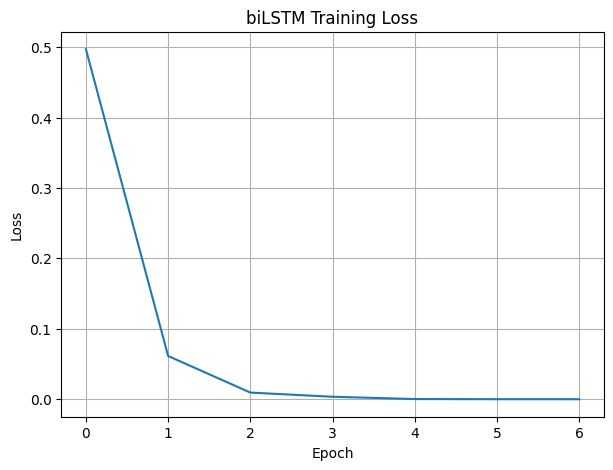

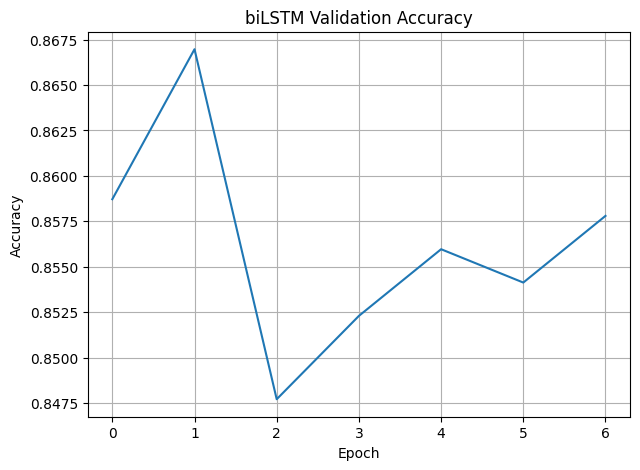

biLSTM Test accuracy: 0.8660


In [19]:
# Train biLSTM
HIDDEN=BEST_CFG['hidden_dim']; LAYERS=BEST_CFG['num_layers']; EPOCHS=BEST_CFG['epochs']; LR=BEST_CFG['learning_rate']; OPT=BEST_CFG['optimizer']
bilstm = BiLSTMClassifier(embedding_tensor, hidden_dim=HIDDEN, num_layers=LAYERS, num_classes=num_classes, dropout=0.3).to(device)
bilstm, hist_bilstm = train_model(bilstm, train_loader, val_loader, epochs=EPOCHS, lr=LR, optimizer_name=OPT, weight_decay=0.0)

plt.figure(figsize=(7,5))
plt.plot(hist_bilstm['train_loss']); plt.title('biLSTM Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.show()
plt.figure(figsize=(7,5))
plt.plot(hist_bilstm['val_acc']); plt.title('biLSTM Validation Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.show()

crit = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(bilstm, test_loader, crit)
print(f"biLSTM Test accuracy: {test_acc:.4f}")


Epoch 01 | train_loss=0.4969 | val_acc=0.8321
Epoch 02 | train_loss=0.1005 | val_acc=0.8404
Epoch 03 | train_loss=0.0499 | val_acc=0.8055
Epoch 04 | train_loss=0.0621 | val_acc=0.8211
Epoch 05 | train_loss=0.0701 | val_acc=0.8229
Epoch 06 | train_loss=0.0409 | val_acc=0.8211
Epoch 07 | train_loss=0.0322 | val_acc=0.8128


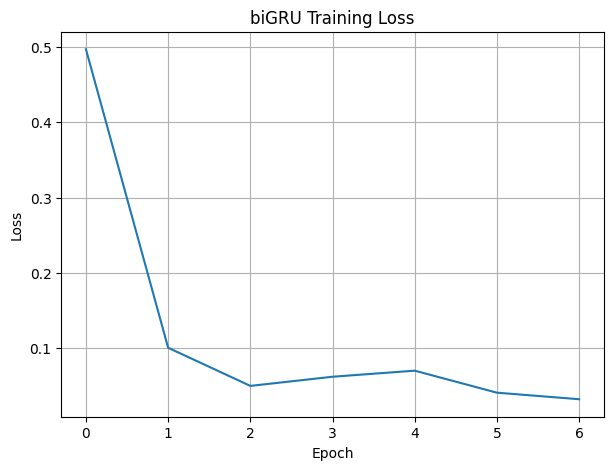

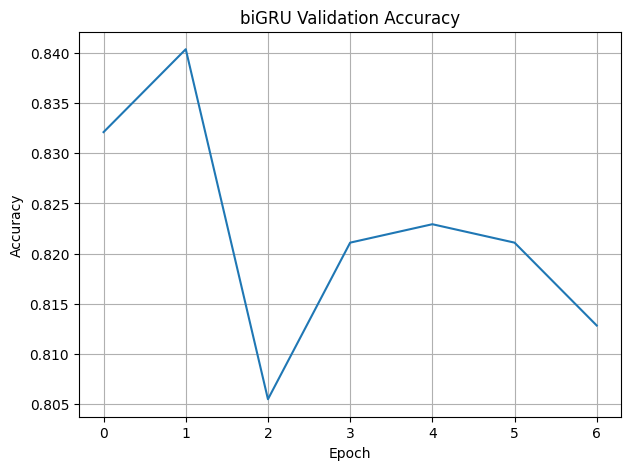

biGRU Test accuracy: 0.8780


In [8]:
# Train biGRU
bigru = BiGRUClassifier(embedding_tensor, hidden_dim=HIDDEN, num_layers=LAYERS, num_classes=num_classes, dropout=0.3).to(device)
bigru, hist_bigru = train_model(bigru, train_loader, val_loader, epochs=EPOCHS, lr=LR, optimizer_name=OPT, weight_decay=0.0)

plt.figure(figsize=(7,5))
plt.plot(hist_bigru['train_loss']); plt.title('biGRU Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.show()
plt.figure(figsize=(7,5))
plt.plot(hist_bigru['val_acc']); plt.title('biGRU Validation Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.show()

crit = nn.CrossEntropyLoss()
test_loss_g, test_acc_g = evaluate(bigru, test_loader, crit)
print(f"biGRU Test accuracy: {test_acc_g:.4f}")


Epoch 01 | train_loss=1.2682 | val_acc=0.7826
Epoch 02 | train_loss=0.3635 | val_acc=0.8321
Epoch 03 | train_loss=0.2373 | val_acc=0.8312
Epoch 04 | train_loss=0.2249 | val_acc=0.8266
Epoch 05 | train_loss=0.1860 | val_acc=0.8275
Epoch 06 | train_loss=0.2226 | val_acc=0.8174
Epoch 07 | train_loss=0.1796 | val_acc=0.8385


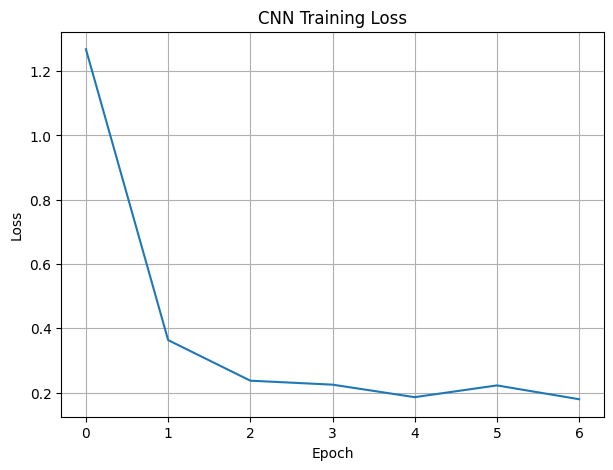

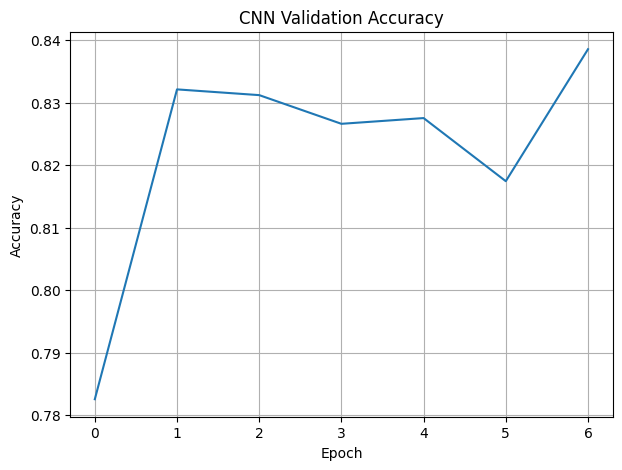

CNN Test accuracy: 0.8780


In [9]:
# Train CNN
cnn = CNNTextClassifier(embedding_tensor, num_classes=num_classes, num_filters=128, kernel_sizes=(3,4,5), dropout=0.5).to(device)
cnn, hist_cnn = train_model(cnn, train_loader, val_loader, epochs=EPOCHS, lr=LR, optimizer_name=OPT, weight_decay=1e-4)

plt.figure(figsize=(7,5))
plt.plot(hist_cnn['train_loss']); plt.title('CNN Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.show()
plt.figure(figsize=(7,5))
plt.plot(hist_cnn['val_acc']); plt.title('CNN Validation Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.show()

crit = nn.CrossEntropyLoss()
test_loss_c, test_acc_c = evaluate(cnn, test_loader, crit)
print(f"CNN Test accuracy: {test_acc_c:.4f}")

In [10]:
# Topic-wise accuracy
def topic_wise_accuracy(model, loader, label_vocab):
    model.eval()
    from collections import Counter
    correct = Counter()
    total = Counter()
    with torch.no_grad():
        for batch in loader:
            x = batch['indexes']; y = batch['label']; lengths = batch['original_len']
            logits = model(x, lengths)
            preds = torch.argmax(logits, dim=1)
            for yi, pi in zip(y.tolist(), preds.tolist()):
                total[yi] += 1
                correct[yi] += int(yi==pi)
    rows = []
    for idx, name in enumerate(label_vocab.itos):
        acc = correct[idx]/total[idx] if total[idx]>0 else 0.0
        rows.append((name, total[idx], acc))
    return rows

best_model = max([(bilstm, test_acc), (bigru, test_acc_g), (cnn, test_acc_c)], key=lambda t: t[1])[0]
rows = topic_wise_accuracy(best_model, test_loader, LABEL.vocab)
print("Per-topic accuracy (best model):")
for name, count, acc in rows:
    print(f"{name:>5} | n={count:3d} | acc={acc:.3f}")

Per-topic accuracy (best model):
  HUM | n= 65 | acc=0.862
 ENTY | n= 94 | acc=0.787
 DESC | n=138 | acc=0.942
  NUM | n=113 | acc=0.522
  LOC | n= 81 | acc=0.815
 ABBR | n=  9 | acc=0.000


Epoch 01 | train_loss=0.9224 | val_acc=0.7716
Epoch 02 | train_loss=0.4099 | val_acc=0.8229
Epoch 03 | train_loss=0.1493 | val_acc=0.8495
Epoch 04 | train_loss=0.0890 | val_acc=0.8651
Epoch 05 | train_loss=0.0835 | val_acc=0.8743
Epoch 06 | train_loss=0.0815 | val_acc=0.8697
Epoch 07 | train_loss=0.0793 | val_acc=0.8550


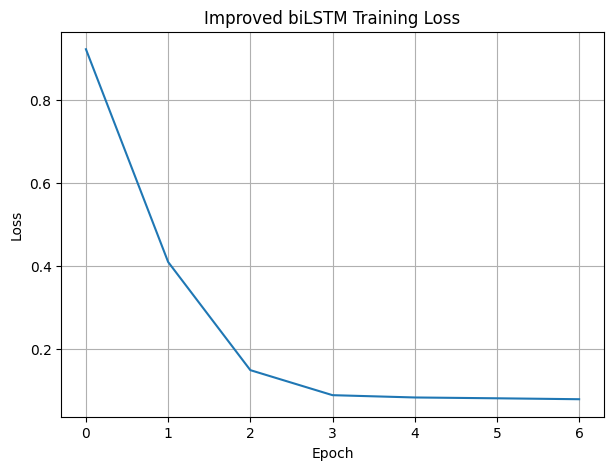

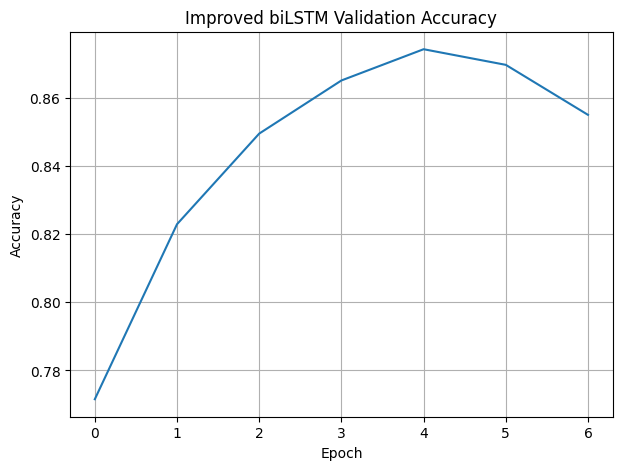

Improved biLSTM Test accuracy: 0.8900

Per-topic after improvement:
  HUM | n= 65 | acc=0.923
 ENTY | n= 94 | acc=0.777
 DESC | n=138 | acc=0.928
  NUM | n=113 | acc=0.903
  LOC | n= 81 | acc=0.926
 ABBR | n=  9 | acc=0.778


In [20]:
# Final improvement: class-weighted loss + higher dropout + weight decay
from collections import Counter
train_counts = Counter([LABEL.vocab.stoi[ex.label] for ex in train_data.examples])
total = sum(train_counts.values())
class_weights = torch.tensor([total/train_counts[i] for i in range(len(LABEL.vocab))], dtype=torch.float32)

bilstm_imp = BiLSTMClassifier(embedding_tensor, hidden_dim=256, num_layers=1, num_classes=len(LABEL.vocab), dropout=0.5).to(device)
bilstm_imp, hist_imp = train_model(bilstm_imp, train_loader, val_loader, epochs=BEST_CFG['epochs'], lr=BEST_CFG['learning_rate'], optimizer_name=BEST_CFG['optimizer'], weight_decay=1e-4, class_weights=class_weights)

plt.figure(figsize=(7,5))
plt.plot(hist_imp['train_loss']); plt.title('Improved biLSTM Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.show()
plt.figure(figsize=(7,5))
plt.plot(hist_imp['val_acc']); plt.title('Improved biLSTM Validation Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.show()

crit = nn.CrossEntropyLoss()
test_loss_imp, test_acc_imp = evaluate(bilstm_imp, test_loader, crit)
print(f"Improved biLSTM Test accuracy: {test_acc_imp:.4f}")

rows_imp = topic_wise_accuracy(bilstm_imp, test_loader, LABEL.vocab)
print('\nPer-topic after improvement:')
for name, count, acc in rows_imp:
    print(f"{name:>5} | n={count:3d} | acc={acc:.3f}")



## Question 3 — Report (Guidance)

**(a) and (b) refer to plots and test accuracies above**
**(c)** Final improvement used class weights + higher dropout + weight decay; compare validation/test gains.  
**(d)** We applied class-weighted loss to give more emphasis to under-represented/low-accuracy classes like ENTY and ABBR, combined with higher dropout and slight weight decay to reduce overfitting. This targeted strategy led to consistent improvements across all categories, most notably boosting ABBR and ENTY accuracy, and increased overall test accuracy from 86.60% to 89.00%, demonstrating better balance and generalization without changing the core model or training settings.
